# Pequeña prueba para ver si guarda bien los archivos

In [ ]:
import torch
import re
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
import seaborn as sns

## Comprobación rápida del Dataset

In [2]:
data_dict = torch.load("Dataset3D_100_model.pth")
dataset = data_dict["dataset"]  # accedes a la lista de grafos
norm_info = data_dict["normalization_info"]  # accedes a los valores máximos

print(f"Dataset .pth cargado con {len(dataset)} grafos.")
graph_idx = 0
data = dataset[graph_idx]


T_input = data.x[:, 1] * norm_info["max_T_env"]
T_real = data.y[:, 0] * norm_info["max_T_real"]

max_T_env = norm_info["max_T_env"]
max_T_real = norm_info["max_T_real"]
max_Qi = norm_info["max_Qi"]

nonzero_indices = (T_input != 0).nonzero(as_tuple=True)[0]
print("Nodos con numeración local y con T_input ≠ 0:", nonzero_indices.tolist())
print("Valores de T_input en esos nodos:", T_input[nonzero_indices].tolist())
print("¿T_input == T_real en todos los nodos?", torch.allclose(T_input, T_real))

assert len(nonzero_indices) == 1, f"Hay {len(nonzero_indices)} nodos con T_input ≠ 0, y debería haber exactamente 1."
print("Confirmado: Solo hay un nodo con T_input ≠ 0.")


C:\Users\ramse\AppData\Local\Temp\ipykernel_9980\3007960386.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load("Dataset3D_100_model.pth")


Dataset .pth cargado con 100 grafos.
Nodos con numeración local y con T_input ≠ 0: [33]
Valores de T_input en esos nodos: [286.65399169921875]
¿T_input == T_real en todos los nodos? False
Confirmado: Solo hay un nodo con T_input ≠ 0.


In [3]:
print("edge_index shape:", data.edge_index.shape)
print("edge_attr shape:", data.edge_attr.shape)
print("Primera fila edge_attr (GL, GR):", data.edge_attr[0])

print(data.edge_attr.shape)           # ¿Tiene 2 columnas?
print(torch.count_nonzero(data.edge_attr[:, 0]))  # ¿Cuántos GL ≠ 0 hay?
GLs = data.edge_attr[:, 0]
print("Valores únicos de GL:", torch.unique(GLs))

print("Node areas:", data.area)
print("GL normalized with area:", data.edge_attr_GLAGRA[:, 0])

edge_index shape: torch.Size([2, 396])
edge_attr shape: torch.Size([396, 2])
Primera fila edge_attr (GL, GR): tensor([1.1803, 0.0000])
torch.Size([396, 2])
tensor(78)
Valores únicos de GL: tensor([0.0000e+00, 6.5111e-02, 2.2080e-01, 7.0480e-01, 7.1368e-01, 7.9558e-01,
        8.5511e-01, 8.5816e-01, 9.3506e-01, 1.1362e+00, 1.1803e+00, 4.6759e+01,
        6.8750e+01, 7.5000e+01, 8.0000e+01, 1.4700e+02])
Node areas: tensor([4.5000e+00, 4.5000e+00, 4.5000e+00, 4.5000e+00, 4.5000e+00, 4.2495e+00,
        4.5000e+00, 4.5000e+00, 4.5000e+00, 4.5000e+00, 1.8000e+00, 1.8800e+00,
        3.0800e+00, 5.0000e-01, 2.0400e+00, 7.5398e-01, 2.6000e+00, 2.5133e-01,
        2.5133e-01, 2.5600e+00, 2.5600e+00, 2.5600e+00, 2.5600e+00, 2.4331e+00,
        2.4331e+00, 2.5600e+00, 2.5600e+00, 2.5600e+00, 2.5600e+00, 2.3100e+00,
        2.3100e+00, 1.3175e+01, 1.3175e+01, 1.0000e+20])
GL normalized with area: tensor([5.8286e-02, 5.8286e-02, 5.8286e-02, 5.8286e-02, 5.8286e-02, 5.8286e-02,
        5.8286e-02, 

In [ ]:

edge_index = data.edge_index.numpy()
edge_attr = data.edge_attr.numpy()
edge_attr_GLAGRA = data.edge_attr_GLAGRA.numpy()
external_ids = data.external_ids.numpy()

# === Crear diccionarios de GL y GR por pares de nodos
gl_dict = {}
gr_dict = {}
gla_dict = {}
gra_dict = {}
for i in range(edge_index.shape[1]):
    u_idx, v_idx = edge_index[:, i]
    u_real = external_ids[u_idx]
    v_real = external_ids[v_idx]
    gl, gr = edge_attr[i]
    gla, gra = edge_attr_GLAGRA[i]
    key = tuple(sorted((u_real, v_real)))  # para simetría

    if gl > 0:
        gl_dict[key] = gl
    if gr > 0:
        gr_dict[key] = gr
    
    if gla > 0:
        gla_dict[key] = gla
    if gra > 0:
        gra_dict[key] = gra

print(f"Total de conexiones con GL > 0: {len(gl_dict)}")
print(f"Total de conexiones con GR > 0: {len(gr_dict)}")

# === Leer archivo de texto con valores esperados de ESATAN
txt_path = "GR_GL_esperados.txt"
with open(txt_path, "r") as f:
    lines = f.readlines()

# === Inicializar patrones y diccionarios
pattern_gl = re.compile(r"GL\((\d+),\s*(\d+)\)\s*=\s*([0-9.D+-]+)")
pattern_gr = re.compile(r"GR\((\d+),\s*(\d+)\)\s*=\s*([0-9.D+-]+)")

expected_gl = {}
expected_gr = {}

for line in lines:
    match_gl = pattern_gl.search(line)
    match_gr = pattern_gr.search(line)

    if match_gl:
        i, j = int(match_gl.group(1)), int(match_gl.group(2))
        val_str = match_gl.group(3).replace("D", "E")
        try:
            expected_gl[tuple(sorted((i, j)))] = float(val_str)
        except ValueError:
            continue

    if match_gr:
        i, j = int(match_gr.group(1)), int(match_gr.group(2))
        val_str = match_gr.group(3).replace("D", "E")
        try:
            expected_gr[tuple(sorted((i, j)))] = float(val_str)
        except ValueError:
            continue

# === Comparación
tolerance = 1e-6

def comparar_dicts(nombre, dict_modelo, dict_esperado):
    coinciden = []
    difieren = []
    faltan = []

    for key, val_txt in dict_esperado.items():
        if key in dict_modelo:
            val_pth = dict_modelo[key]
            if abs(val_txt - val_pth) < tolerance:
                coinciden.append((key, val_txt, val_pth))
            else:
                difieren.append((key, val_txt, val_pth))
        else:
            faltan.append((key, val_txt))

    print(f" Resultados comparación de {nombre}:")
    print(f" Coincidencias exactas (tol={tolerance}) : {len(coinciden)}")
    print(f" Diferencias fuera de tolerancia         : {len(difieren)}")
    print(f" Conexiones que faltan en el .pth        : {len(faltan)}")

    if difieren:
        print(f"\n--- Diferencias {nombre} (máx 5) ---")
        for key, val_txt, val_pth in difieren[:5]:
            print(f"{key}: texto={val_txt:.6e}, pth={val_pth:.6e}")

    if faltan:
        print(f"\n--- Faltan en .pth {nombre} (máx 5) ---")
        for key, val_txt in faltan[:5]:
            print(f"{key}: texto={val_txt:.6e}")

# === Comparar GL y GR
comparar_dicts("GL", gl_dict, expected_gl)
comparar_dicts("GR", gr_dict, expected_gr)

# === Estadísticas adicionales
gl_vals = np.array(list(gl_dict.values()))
gr_vals = np.array(list(gr_dict.values()))

print(f"\nGL - min: {gl_vals.min():.2e}, max: {gl_vals.max():.2e}, mean: {gl_vals.mean():.2e}" if len(gl_vals) > 0 else "GL vacío")
print(f"GR - min: {gr_vals.min():.2e}, max: {gr_vals.max():.2e}, mean: {gr_vals.mean():.2e}" if len(gr_vals) > 0 else "GR vacío")
faltan_en_pth_gl = [k for k in expected_gl if k not in gl_dict]
print(f"Conexiones GL que faltan en el .pth: {len(faltan_en_pth_gl)}")
for k in faltan_en_pth_gl:
    print(f"Falta: {k} = {expected_gl[k]:.6e}")
    
"""-------------------------------------------------------------------------"""
print(f"Total de conexiones con GLA > 0: {len(gla_dict)}")
print(f"Total de conexiones con GRA > 0: {len(gra_dict)}")
gla_vals = np.array(list(gla_dict.values()))
gra_vals = np.array(list(gra_dict.values()))

print(f"\nGLA - min: {gla_vals.min():.2e}, max: {gla_vals.max():.2e}, mean: {gla_vals.mean():.2e}" if len(gla_vals) > 0 else "GLA vacío")
print(f"GRA - min: {gra_vals.min():.2e}, max: {gra_vals.max():.2e}, mean: {gra_vals.mean():.2e}" if len(gra_vals) > 0 else "GRA vacío")



Total de conexiones con GL > 0: 39
Total de conexiones con GR > 0: 159



🔍 Resultados comparación de GL:
✔ Coincidencias exactas (tol=1e-06) : 20
✘ Diferencias fuera de tolerancia         : 19
⚠ Conexiones que faltan en el .pth        : 0

--- Diferencias GL (máx 5) ---
(10000, 10001): texto=1.000000e+00, pth=1.180289e+00
(10000, 10002): texto=1.000000e+00, pth=1.180289e+00
(10000, 10003): texto=1.000000e+00, pth=1.180289e+00
(10000, 10004): texto=1.000000e+00, pth=1.180289e+00
(10000, 33000): texto=2.500000e-01, pth=6.875000e+01

🔍 Resultados comparación de GR:
✔ Coincidencias exactas (tol=1e-06) : 159
✘ Diferencias fuera de tolerancia         : 0
⚠ Conexiones que faltan en el .pth        : 0

GL - min: 6.51e-02, max: 1.47e+02, mean: 1.34e+01
GR - min: 1.77e-07, max: 1.01e+01, mean: 2.32e-01
Conexiones GL que faltan en el .pth: 0
Total de conexiones con GLA > 0: 39
Total de conexiones con GRA > 0: 159

GLA - min: 1.10e-03, max: 3.06e+01, mean: 2.03e+00
GRA - min: 9.83e-09, max: 7.61e-01, mean: 2.71e-02


Shape del DataFrame: (100, 69)


,T_env,Qi_10000,T_10000,Qi_10001,T_10001,Qi_10002,T_10002,Qi_10003,T_10003,Qi_10004,...,Qi_60000,T_60000,Qi_60100,T_60100,Qi_70000,T_70000,Qi_72000,T_72000,Qi_99999,T_99999
0,286.653992,0.0,308.799988,0.0,310.677307,0.0,310.732117,0.0,310.652802,0.0,...,0.0,308.838715,0.0,286.653992,0.0,286.683228,0.0,286.683228,0.0,286.653992
1,303.904999,0.0,325.243958,0.0,327.156311,0.0,327.202393,0.0,327.131165,0.0,...,0.0,325.293732,0.0,303.904999,0.0,303.928772,0.0,303.928772,0.0,303.904999
2,306.870026,0.0,327.654663,0.0,329.646057,0.0,329.690887,0.0,329.620850,0.0,...,0.0,327.723450,0.0,306.869995,0.0,306.892639,0.0,306.892639,0.0,306.869995
3,287.494995,0.0,308.457672,0.0,310.224976,0.0,310.272797,0.0,310.199341,0.0,...,0.0,308.491211,0.0,287.494995,0.0,287.522430,0.0,287.522400,0.0,287.494995
4,272.730011,0.0,300.723877,0.0,302.975342,0.0,303.050323,0.0,302.948059,0.0,...,0.0,300.765625,0.0,272.730011,0.0,272.772675,0.0,272.772675,0.0,272.730011


Estadísticas de T_env + Qi:


,T_env,Qi_10000,Qi_10001,Qi_10002,Qi_10003,Qi_10004,Qi_10005,Qi_12000,Qi_13000,Qi_14000,...,Qi_50500,Qi_50600,Qi_50700,Qi_50800,Qi_50900,Qi_60000,Qi_60100,Qi_70000,Qi_72000,Qi_99999
count,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
mean,287.069335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,13.987628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,261.063019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,275.263496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,286.320999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,300.131500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,309.294006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


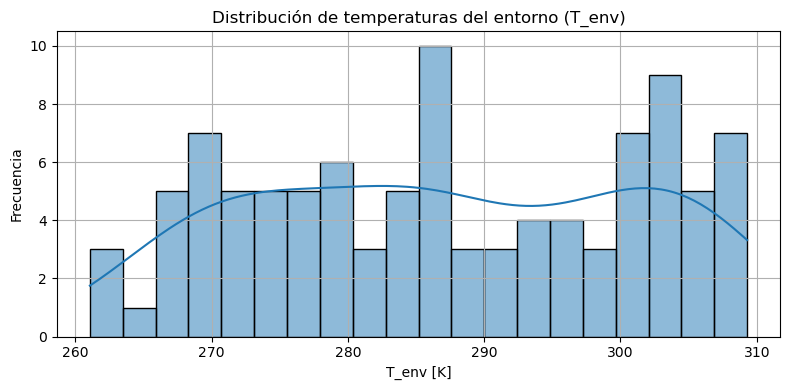

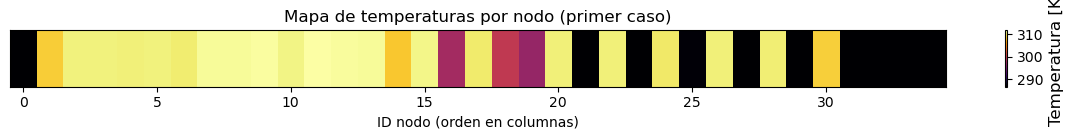

 Perfecto, el nodo 99999 no tiene ninguna conexión con GL > 0.
Conductancias GL (ordenadas de mayor a menor):


Conexion,13000 → 32000,32000 → 13000,30000 → 14000,14000 → 30000,12000 → 31000,31000 → 12000,15000 → 34000,34000 → 15000,10000 → 33000,33000 → 10000,...,99999 → 10002,50400 → 10002,10002 → 99999,60000 → 10002,10002 → 60000,50800 → 10002,10002 → 50800,50600 → 10002,10002 → 50600,99999 → 72000
GL,147.0,147.0,80.0,80.0,75.0,75.0,75.0,75.0,68.75,68.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Conductancias GR (ordenadas de mayor a menor):


Conexion,99999 → 70000,70000 → 99999,99999 → 72000,72000 → 99999,14000 → 13000,13000 → 14000,12000 → 14000,14000 → 12000,15000 → 10000,10000 → 15000,...,10004 → 10003,10003 → 10005,10005 → 10003,10003 → 12000,12000 → 10003,10003 → 13000,13000 → 10003,10003 → 14000,14000 → 10003,10000 → 10001
GR,10.07633,10.07633,10.06498,10.06498,0.604502,0.604502,0.591389,0.591389,0.572638,0.572638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Máximo GL: 1.470e+02 en 13000 → 32000
Mínimo GL: 6.511e-02 en 10001 → 70000

Máximo GR: 1.008e+01 en 70000 → 99999
Mínimo GR: 1.775e-07 en 10005 → 99999


In [5]:
# === Extraer datos a DataFrame ===
data_rows = []
for data in dataset:
    row = {}
    external_ids = data.external_ids.tolist()

    Qi_vals = (data.x[:, 0] * max_Qi).tolist()          # desnormalizar Qi
    T_input_vals = (data.x[:, 1] * max_T_env).tolist()  # desnormalizar T_env
    T_real_vals = (data.y[:, 0] * max_T_real).tolist()  # desnormalizar T_real

    #----------Descomentar si se quiere ver los valores normalizados----------
    
    # Qi_vals = data.x[:, 0].tolist()
    # T_input_vals = data.x[:, 1].tolist()
    # T_real_vals = data.y[:, 0].tolist()
    
    # T_env solo está en el nodo 99999 → extraerlo
    idx_env = external_ids.index(99999)
    row["T_env"] = T_input_vals[idx_env]
    
    # Guardar cada Qi_i y T_i (real)
    for idx, ext_id in enumerate(external_ids):
        row[f"Qi_{ext_id}"] = Qi_vals[idx]
        row[f"T_{ext_id}"] = T_real_vals[idx]
        
    data_rows.append(row)

df = pd.DataFrame(data_rows)

# === Mostrar primeras filas y shape
print(f"Shape del DataFrame: {df.shape}")
display(df.head())

# === Estadísticas de entradas
print("Estadísticas de T_env + Qi:")
display(df.filter(regex=r"^(T_env|Qi_)").describe())

# === Histograma de T_env
plt.figure(figsize=(8, 4))
sns.histplot(df["T_env"], bins=20, kde=True)
plt.title("Distribución de temperaturas del entorno (T_env)")
plt.xlabel("T_env [K]")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Mapa de calor de temperaturas reales del primer caso
t_columns = [col for col in df.columns if col.startswith("T_")]
t_vals = df[t_columns].iloc[0].values

plt.figure(figsize=(12, 1.5))
img = plt.imshow([t_vals], aspect="auto", cmap="inferno")
cbar = plt.colorbar(img)
cbar.set_label("Temperatura [K]", fontsize=12)
plt.title("Mapa de temperaturas por nodo (primer caso)")
plt.xlabel("ID nodo (orden en columnas)")
plt.yticks([])
plt.tight_layout()
plt.show()

# === Crear tabla de GL y GR para el primer grafo ===
data = dataset[0]
external_ids = data.external_ids.tolist()
edge_index = data.edge_index.numpy()
edge_attr = data.edge_attr.numpy()

# Crear tabla de conductancias
rows = []
for idx, (u, v) in enumerate(edge_index.T):
    gl = edge_attr[idx, 0]
    gr = edge_attr[idx, 1]
    if gl > 0 or gr > 0:
        rows.append({
            "Origen": external_ids[u],
            "Destino": external_ids[v],
            "Conexion": f"{external_ids[u]} → {external_ids[v]}",
            "GL": gl,
            "GR": gr
        })

df_conduct = pd.DataFrame(rows)

# Ordenar por GL de mayor a menor
df_sorted_GL = df_conduct.sort_values(by="GL", ascending=False).reset_index(drop=True)
df_GL_transposed = df_sorted_GL[["Conexion", "GL"]].set_index("Conexion").T

# Verifica si hay alguna conexión GL > 0 con el nodo 99999
hay_conexion_GL = df_conduct[
    (df_conduct["GL"] > 0) &
    ((df_conduct["Origen"] == 99999) | (df_conduct["Destino"] == 99999))
].shape[0] > 0

# Mostrar resultado
if hay_conexion_GL:
    print(" CUIDADO. El nodo 99999 tiene al menos una conexión con GL > 0.")
else:
    print(" Perfecto, el nodo 99999 no tiene ninguna conexión con GL > 0.")



# Ordenar por GR de mayor a menor
df_sorted_GR = df_conduct.sort_values(by="GR", ascending=False).reset_index(drop=True)
df_GR_transposed = df_sorted_GR[["Conexion", "GR"]].set_index("Conexion").T

# Mostrar tablas transpuestas
print("Conductancias GL (ordenadas de mayor a menor):")
display(df_GL_transposed)

print("Conductancias GR (ordenadas de mayor a menor):")
display(df_GR_transposed)

# GL
gl_nonzero = df_conduct[df_conduct["GL"] > 0]
gl_min_row = gl_nonzero.loc[gl_nonzero["GL"].idxmin()]
gl_max_row = df_conduct.loc[df_conduct["GL"].idxmax()]

# GR
gr_nonzero = df_conduct[df_conduct["GR"] > 0]
gr_min_row = gr_nonzero.loc[gr_nonzero["GR"].idxmin()]
gr_max_row = df_conduct.loc[df_conduct["GR"].idxmax()]

print(f"\nMáximo GL: {gl_max_row['GL']:.3e} en {gl_max_row['Conexion']}")
print(f"Mínimo GL: {gl_min_row['GL']:.3e} en {gl_min_row['Conexion']}")
print(f"\nMáximo GR: {gr_max_row['GR']:.3e} en {gr_max_row['Conexion']}")
print(f"Mínimo GR: {gr_min_row['GR']:.3e} en {gr_min_row['Conexion']}")


## Visualización de las características del grafo

In [6]:
# === Elegir índice del grafo a visualizar ===

print(f"Grafo {graph_idx}: {data}")

# === Extraer datos y desnormalizarlos ===
Qi = data.x[:, 0].numpy() * norm_info["max_Qi"]
T_input = data.x[:, 1].numpy() * norm_info["max_T_env"]
T_real = data.y[:, 0].numpy() * norm_info["max_T_real"]
external_ids = data.external_ids.numpy()

# === Crear grafo con nodos identificados por external_id ===
G = nx.Graph()

# Añadir nodos con atributos
for idx, node_id in enumerate(external_ids):
    G.add_node(
        node_id,
        Qi=Qi[idx],
        T_input=T_input[idx],
        T_real=T_real[idx]
    )

edge_index = data.edge_index.numpy()
edge_attr = data.edge_attr.numpy()
external_ids = data.external_ids.numpy()

# Diccionario para almacenar la arista única por par
edge_dict = {}

for j in range(edge_index.shape[1]):
    u_idx = edge_index[0, j]
    v_idx = edge_index[1, j]
    u_real = external_ids[u_idx]
    v_real = external_ids[v_idx]
    key = tuple(sorted((u_real, v_real)))

    # Acumular (usa el mayor GL/GR en caso de duplicado)
    gl, gr = edge_attr[j, 0], edge_attr[j, 1]
    if key in edge_dict:
        edge_dict[key]["GL"] = max(edge_dict[key]["GL"], gl)
        edge_dict[key]["GR"] = max(edge_dict[key]["GR"], gr)
    else:
        edge_dict[key] = {"GL": gl, "GR": gr}

# Añadir aristas únicas al grafo G
for (u, v), attr in edge_dict.items():
    G.add_edge(u, v, **attr)

# Layout para visualización
pos = nx.spring_layout(G, seed=42)  # Puedes cambiarlo por nx.kamada_kawai_layout(G) si prefieres


Grafo 0: Data(x=[34, 2], edge_index=[2, 396], edge_attr=[396, 2], y=[34, 1], edge_attr_GLAGRA=[396, 2], external_ids=[34], area=[34])


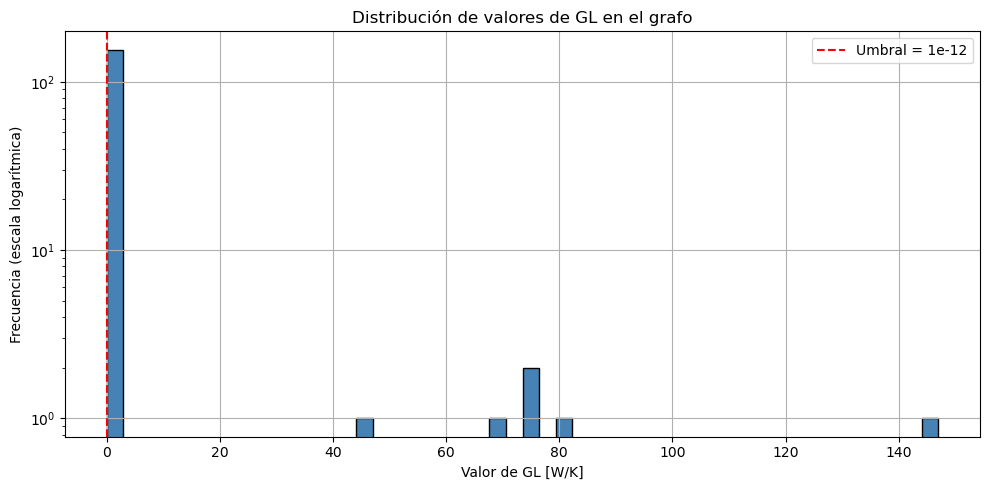

Número de conexiones con 1e-8 < GL < 1000: 39
Valores intermedios encontrados:
0.065111
0.065111
0.220800
0.704800
0.713679
0.795580
0.795580
0.795580
0.795580
0.855107
0.855107
0.855107
0.855107
0.858164
0.858164
0.858164
0.858164
0.935065
0.935065
0.935065
0.935065
1.136202
1.136202
1.136202
1.136202
1.180289
1.180289
1.180289
1.180289
1.180289
1.180289
1.180289
1.180289
46.758751
68.750000
75.000000
75.000000
80.000000
147.000000


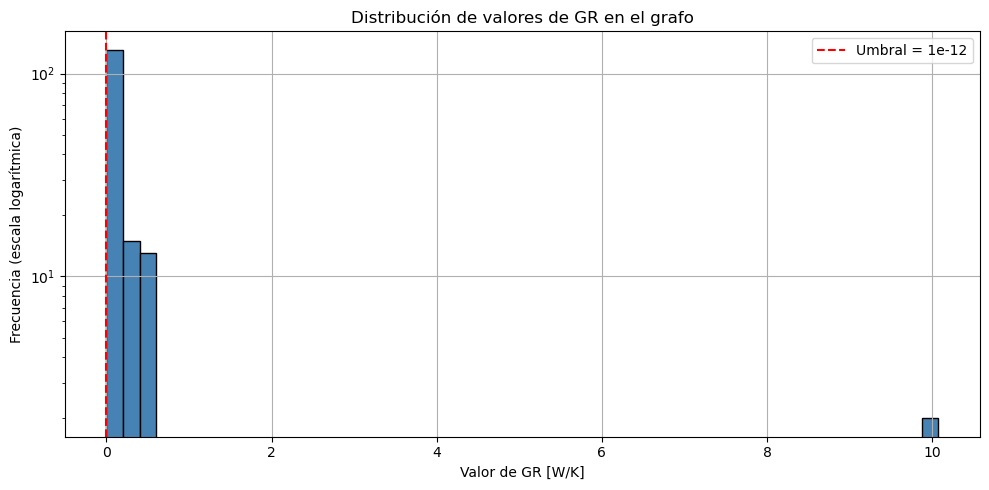

Número de conexiones con 1e-8 < GR < 1000: 159
Valores intermedios encontrados:
0.000000
0.000000
0.000033
0.000037
0.000055
0.000066
0.000071
0.000072
0.000074
0.000081
0.000086
0.000087
0.000117
0.000121
0.000142
0.000143
0.000155
0.000166
0.000170
0.000182
0.000197
0.000197
0.000197
0.000364
0.000367
0.000556
0.005347
0.005499
0.005753
0.006016
0.006080
0.006088
0.006119
0.006121
0.006190
0.006235
0.006351
0.006403
0.006527
0.006530
0.006641
0.006901
0.007283
0.008391
0.008510
0.008541
0.009491
0.009905
0.009963
0.010181
0.010203
0.010219
0.010287
0.010447
0.010461
0.010465
0.010474
0.010484
0.010547
0.010606
0.010610
0.010622
0.010652
0.010740
0.010746
0.010781
0.010786
0.011017
0.011097
0.011173
0.011205
0.011254
0.012083
0.013899
0.015227
0.025761
0.026655
0.030401
0.030617
0.030640
0.031850
0.036305
0.036593
0.036748
0.036855
0.048061
0.059730
0.067314
0.067561
0.067744
0.068048
0.070234
0.070728
0.071435
0.072966
0.077597
0.080605
0.082090
0.082386
0.087811
0.097459
0.104281
0.

In [7]:
# Extraer todos los valores de GL
weights_GL = [G[u][v]['GL'] for u, v in G.edges if 'GL' in G[u][v]]
weights_GR = [G[u][v]['GR'] for u, v in G.edges if 'GR' in G[u][v]]
# Parámetro de umbral visual (puedes cambiarlo)
umbral = 1e-12

# Histograma con escala logarítmica en el eje Y
plt.figure(figsize=(10, 5))
plt.hist(weights_GL, bins=50, log=True, color='steelblue', edgecolor='black')
plt.axvline(x=umbral, color='red', linestyle='--', label=f"Umbral = {umbral:.0e}")

plt.xlabel("Valor de GL [W/K]")
plt.ylabel("Frecuencia (escala logarítmica)")
plt.title("Distribución de valores de GL en el grafo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# # Extraer y filtrar valores de GL menores o iguales a 1000
# weights_GL = [G[u][v]['GL'] for u, v in G.edges if 'GL' in G[u][v] and G[u][v]['GL'] <= 1000]
# weights_GL = [G[u][v]['GR'] for u, v in G.edges if 'GL' in G[u][v] and G[u][v]['GL'] <= 1000]

vals_intermedios_GL = [G[u][v]['GL'] for u, v in G.edges if umbral < G[u][v]['GL'] < 1000]
print(f"Número de conexiones con 1e-8 < GL < 1000: {len(vals_intermedios_GL)}")
print("Valores intermedios encontrados:")
for val in sorted(vals_intermedios_GL):
    print(f"{val:.6f}")
    
# Histograma con escala logarítmica en el eje Y
plt.figure(figsize=(10, 5))
plt.hist(weights_GR, bins=50, log=True, color='steelblue', edgecolor='black')
plt.axvline(x=umbral, color='red', linestyle='--', label=f"Umbral = {umbral:.0e}")

plt.xlabel("Valor de GR [W/K]")
plt.ylabel("Frecuencia (escala logarítmica)")
plt.title("Distribución de valores de GR en el grafo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

vals_intermedios_GR = [G[u][v]['GR'] for u, v in G.edges if umbral < G[u][v]['GR'] < 1000]
print(f"Número de conexiones con 1e-8 < GR < 1000: {len(vals_intermedios_GR)}")
print("Valores intermedios encontrados:")
for val in sorted(vals_intermedios_GR):
    print(f"{val:.6f}")


## Temperatura de entrada

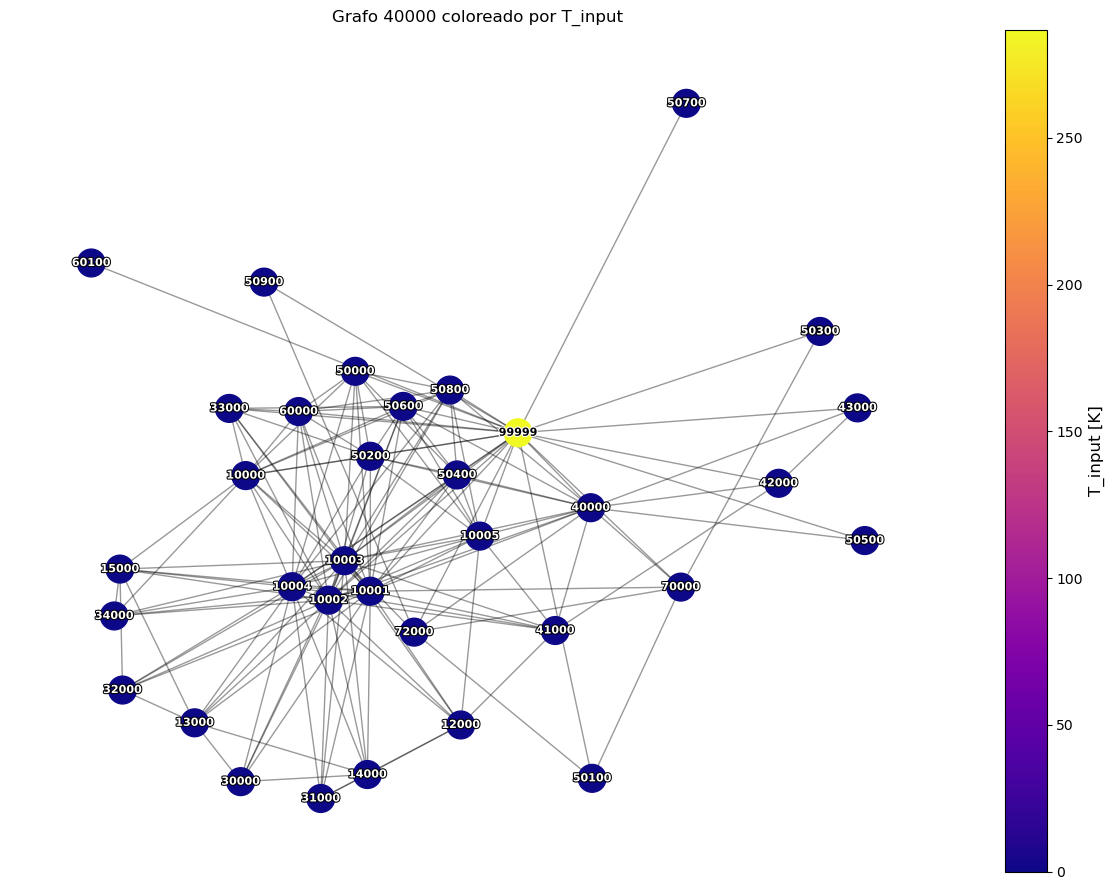

In [8]:
# === Visualización T_input ===
plt.figure(figsize=(12, 9))
node_color_attr = "T_input"
colors = [G.nodes[n][node_color_attr] for n in G.nodes]

norm = mcolors.Normalize(vmin=min(colors), vmax=max(colors))
cmap = plt.get_cmap("plasma")

nodes = nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=cmap, node_size=400)
nx.draw_networkx_edges(G, pos, alpha=0.4)

for n in G.nodes:
    val = G.nodes[n][node_color_attr]
    rgba = cmap(norm(val))
    brightness = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
    label_color = "white" if brightness < 0.5 else "black"

    txt = plt.text(pos[n][0], pos[n][1], str(n),  # usamos el external_id como etiqueta
                   fontsize=8, ha='center', va='center', color=label_color,
                   fontweight='bold')
    stroke_color = "black" if label_color == "white" else "white"
    txt.set_path_effects([
        path_effects.Stroke(linewidth=1.5, foreground=stroke_color),
        path_effects.Normal()
    ])

cbar = plt.colorbar(nodes)
cbar.set_label(f"{node_color_attr} [K]", fontsize=12)
plt.title(f"Grafo {i} coloreado por {node_color_attr}")
plt.axis("off")
plt.tight_layout()
plt.show()


## Potencias de entrada

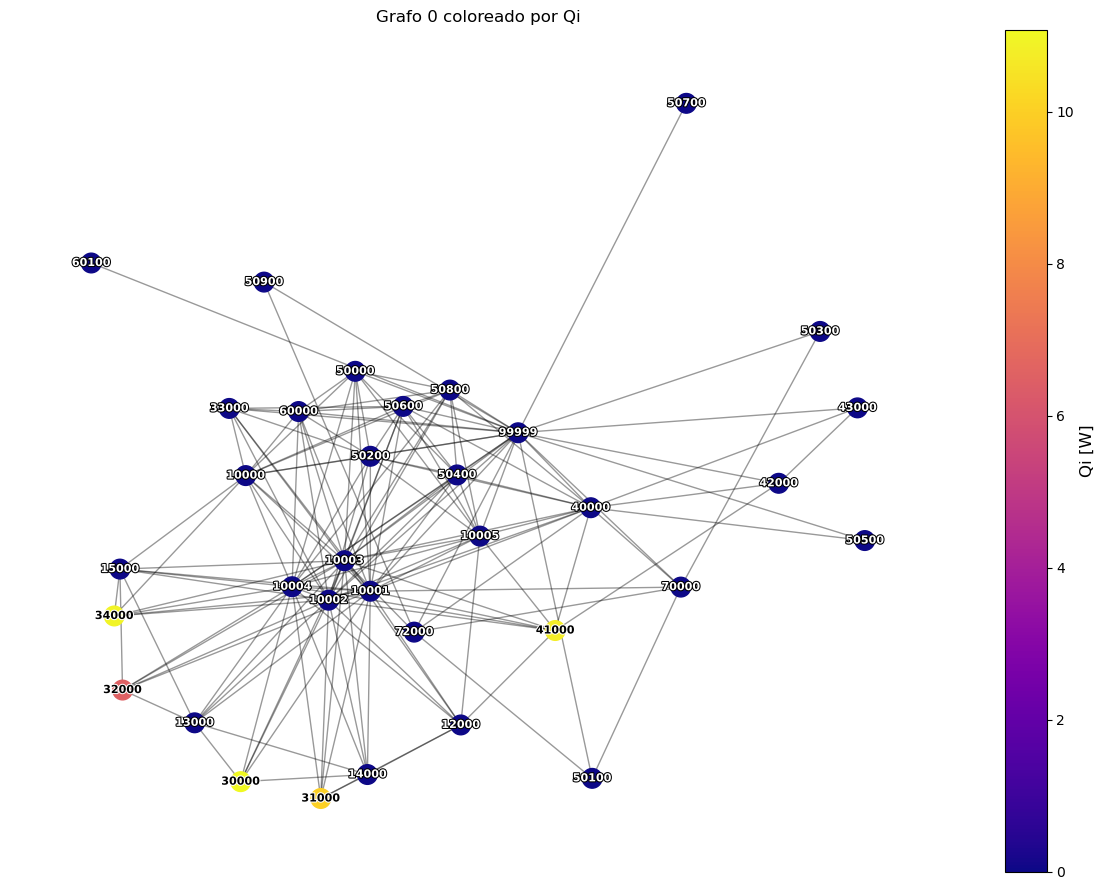

In [9]:
# === Visualización Qi ===
plt.figure(figsize=(12, 9))
node_color_attr = "Qi"
colors = [G.nodes[n][node_color_attr] for n in G.nodes]

norm = mcolors.Normalize(vmin=min(colors), vmax=max(colors))
cmap = plt.get_cmap("plasma")

nodes = nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=cmap, node_size=200)
nx.draw_networkx_edges(G, pos, alpha=0.4)

for n in G.nodes:
    val = G.nodes[n][node_color_attr]
    rgba = cmap(norm(val))
    brightness = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
    label_color = "white" if brightness < 0.5 else "black"

    txt = plt.text(pos[n][0], pos[n][1], str(n),
                   fontsize=8, ha='center', va='center', color=label_color,
                   fontweight='bold')
    stroke_color = "black" if label_color == "white" else "white"
    txt.set_path_effects([
        path_effects.Stroke(linewidth=1.5, foreground=stroke_color),
        path_effects.Normal()
    ])

cbar = plt.colorbar(nodes)
cbar.set_label(f"{node_color_attr} [W]", fontsize=12)
plt.title(f"Grafo {graph_idx} coloreado por {node_color_attr}")
plt.axis("off")
plt.tight_layout()
plt.show()


## Temperatura calculada por el solver

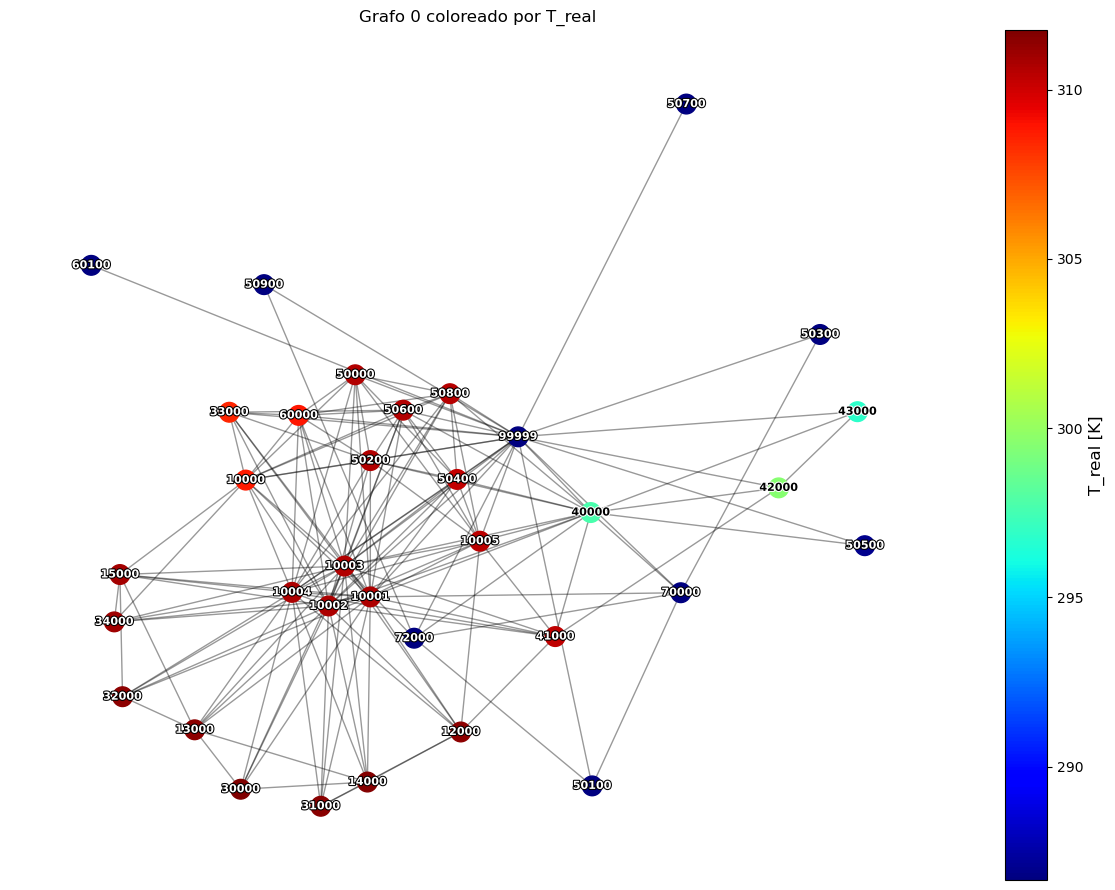

In [10]:
# === Visualización T_real ===
plt.figure(figsize=(12, 9))
node_color_attr = "T_real"
colors = [G.nodes[n][node_color_attr] for n in G.nodes]

norm = mcolors.Normalize(vmin=min(colors), vmax=max(colors))
cmap = plt.get_cmap("jet")

nodes = nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=cmap, node_size=200)
nx.draw_networkx_edges(G, pos, alpha=0.4)

for n in G.nodes:
    val = G.nodes[n][node_color_attr]
    rgba = cmap(norm(val))
    brightness = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
    label_color = "white" if brightness < 0.5 else "black"

    txt = plt.text(pos[n][0], pos[n][1], str(n),
                   fontsize=8, ha='center', va='center', color=label_color,
                   fontweight='bold')
    stroke_color = "black" if label_color == "white" else "white"
    txt.set_path_effects([
        path_effects.Stroke(linewidth=1.5, foreground=stroke_color),
        path_effects.Normal()
    ])

cbar = plt.colorbar(nodes)
cbar.set_label(f"{node_color_attr} [K]", fontsize=12)
plt.title(f"Grafo {graph_idx} coloreado por {node_color_attr}")
plt.axis("off")
plt.tight_layout()
plt.show()


## Conductancias

Total de aristas: 161
Con GL = 0         : 122
Con GL > 1000      : 0
Con 1e-08 < GL ≤ 1000: 39
Nodos en G: [10000, 10001, 10002, 10003, 10004, 10005, 12000, 13000, 14000, 15000, 30000, 31000, 32000, 33000, 34000, 40000, 41000, 42000, 43000, 50000, 50100, 50200, 50300, 50400, 50500, 50600, 50700, 50800, 50900, 60000, 60100, 70000, 72000, 99999]
Nodos en pos: dict_keys([10000, 10001, 10002, 10003, 10004, 10005, 12000, 13000, 14000, 15000, 30000, 31000, 32000, 33000, 34000, 40000, 41000, 42000, 43000, 50000, 50100, 50200, 50300, 50400, 50500, 50600, 50700, 50800, 50900, 60000, 60100, 70000, 72000, 99999])
Nodos sin posición: []


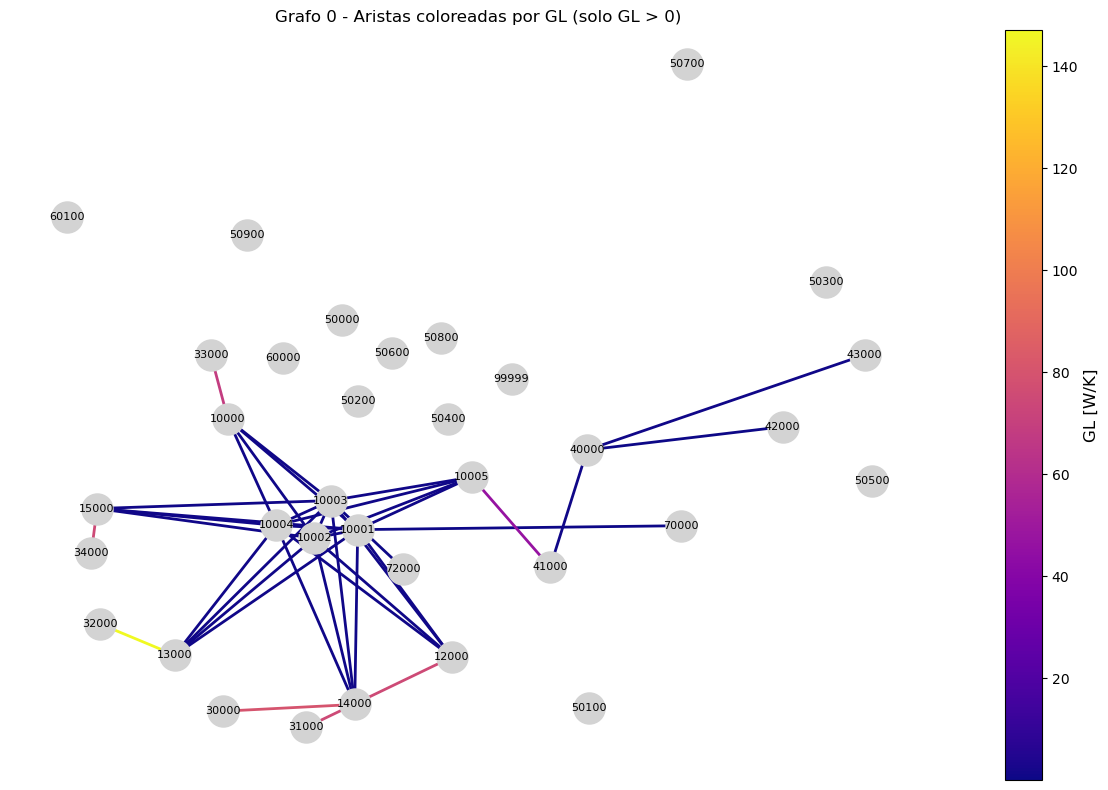

In [11]:
# === Visualización GL con opción a usar edges o edges_filtered ===

total_edges = len(G.edges)
num_GL_0 = sum(1 for u, v in G.edges if G[u][v]['GL'] == 0)
num_GL_big = sum(1 for u, v in G.edges if G[u][v]['GL'] > 1000)
num_GL_mid = sum(1 for u, v in G.edges if 1e-8 < G[u][v]['GL'] <= 1000)

print(f"Total de aristas: {total_edges}")
print(f"Con GL = 0         : {num_GL_0}")
print(f"Con GL > 1000      : {num_GL_big}")
print(f"Con {1e-8:.0e} < GL ≤ 1000: {num_GL_mid}")

# === Preparar pesos GL y aristas ===
edges_all = list(G.edges())
weights_all = [G[u][v]['GL'] for u, v in edges_all]

# Filtro para GL > 0
edges_filtered = [e for i, e in enumerate(edges_all) if weights_all[i] > 0]
weights_filtered = [w for w in weights_all if w > 0]

# Elegir qué conjunto usar
use_filtered = True  # ← cámbialo a True para ocultar GL=0
edges_to_plot = edges_filtered if use_filtered else edges_all
weights_to_plot = weights_filtered if use_filtered else weights_all

# === Normalización y colores ===
if len(weights_to_plot) > 0:
    vmin = min(weights_to_plot)
    vmax = max(weights_to_plot)
else:
    vmin = 0
    vmax = 1

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("plasma")
edge_colors = [cmap(norm(w)) for w in weights_to_plot]

# === Crear figura ===
fig, ax = plt.subplots(figsize=(12, 8))

print("Nodos en G:", G.nodes)
print("Nodos en pos:", pos.keys())
print("Nodos sin posición:", [n for n in G.nodes if n not in pos])


# Nodos y etiquetas
nx.draw_networkx_nodes(G, pos, ax=ax, node_color="lightgray", node_size=500)
nx.draw_networkx_labels(G, pos, ax=ax, labels={n: str(n) for n in G.nodes}, font_size=8)

# Aristas coloreadas por GL
nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edges_to_plot, edge_color=edge_colors, width=2)

# Barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(weights_to_plot)  # importante para que escale bien
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("GL [W/K]", fontsize=12)

# Título
modo = "solo GL > 0" if use_filtered else "todas las aristas"
plt.title(f"Grafo {graph_idx} - Aristas coloreadas por GL ({modo})")
plt.axis("off")
plt.tight_layout()
plt.show()


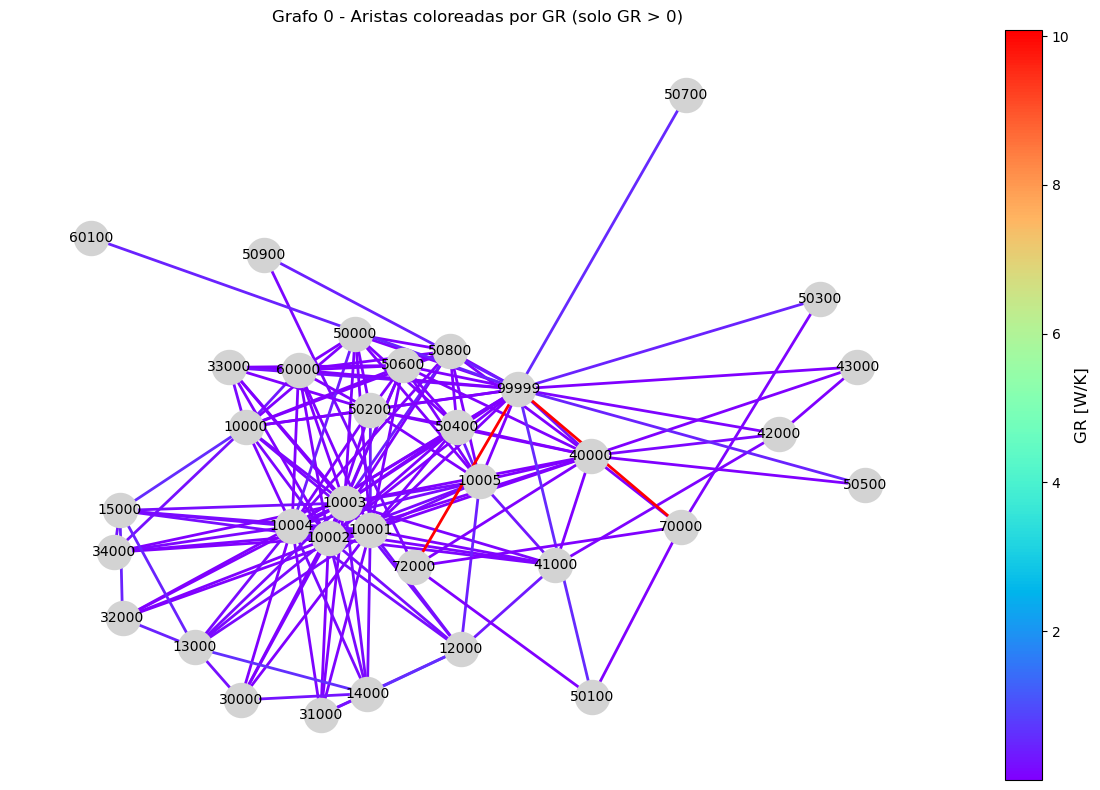

Total de aristas: 161
Con GR = 0         : 2
Con GR > 10      : 2
Con 1e-08 < GR ≤ 10: 157


In [16]:
# === Visualización GR con opción a usar edges o edges_filtered ===

# Preparar pesos GR
edges = list(G.edges())
weights_GR = [G[u][v]['GR'] for u, v in edges]

# Filtros para mostrar solo los que tengan GL > 0
edges_filtered = [e for i, e in enumerate(edges) if weights_GR[i] > 0]
weights_filtered = [w for w in weights_GR if w > 0]

# Elegir qué conjunto usar para visualizar
use_filtered = True  # ← CAMBIA AQUÍ entre True o False
edges_to_plot = edges_filtered if use_filtered else edges
weights_to_plot = weights_filtered if use_filtered else weights_GR

# Normalización para color
if weights_to_plot:
    norm = mcolors.Normalize(vmin=min(weights_to_plot), vmax=max(weights_to_plot))
else:
    norm = mcolors.Normalize(vmin=0, vmax=1)

cmap = plt.get_cmap("rainbow")
edge_colors = [cmap(norm(w)) for w in weights_to_plot]

# Crear figura y eje explícito
fig, ax = plt.subplots(figsize=(12, 8))

# Dibujar nodos
nx.draw_networkx_nodes(G, pos, ax=ax, node_color="lightgray", node_size=600)
nx.draw_networkx_labels(G, pos, ax=ax, labels={n: str(n) for n in G.nodes}, font_size=10)

# Dibujar aristas coloreadas por GL
nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edges_to_plot, edge_color=edge_colors, width=2)

# Barra de color con eje asociado
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("GR [W/K]", fontsize=12)

# Título
label = "solo GR > 0" if use_filtered else "todas las aristas"
plt.title(f"Grafo {graph_idx} - Aristas coloreadas por GR ({label})")
plt.axis("off")
plt.tight_layout()
plt.show()

total_edges = len(G.edges)
num_GR_0 = sum(1 for u, v in G.edges if G[u][v]['GR'] == 0)
num_GR_big = sum(1 for u, v in G.edges if G[u][v]['GR'] > 10)
num_GR_mid = sum(1 for u, v in G.edges if 1e-8 < G[u][v]['GR'] <= 10)

print(f"Total de aristas: {total_edges}")
print(f"Con GR = 0         : {num_GR_0}")
print(f"Con GR > 10      : {num_GR_big}")
print(f"Con {1e-8:.0e} < GR ≤ 10: {num_GR_mid}")


## Matrices de adyacencia

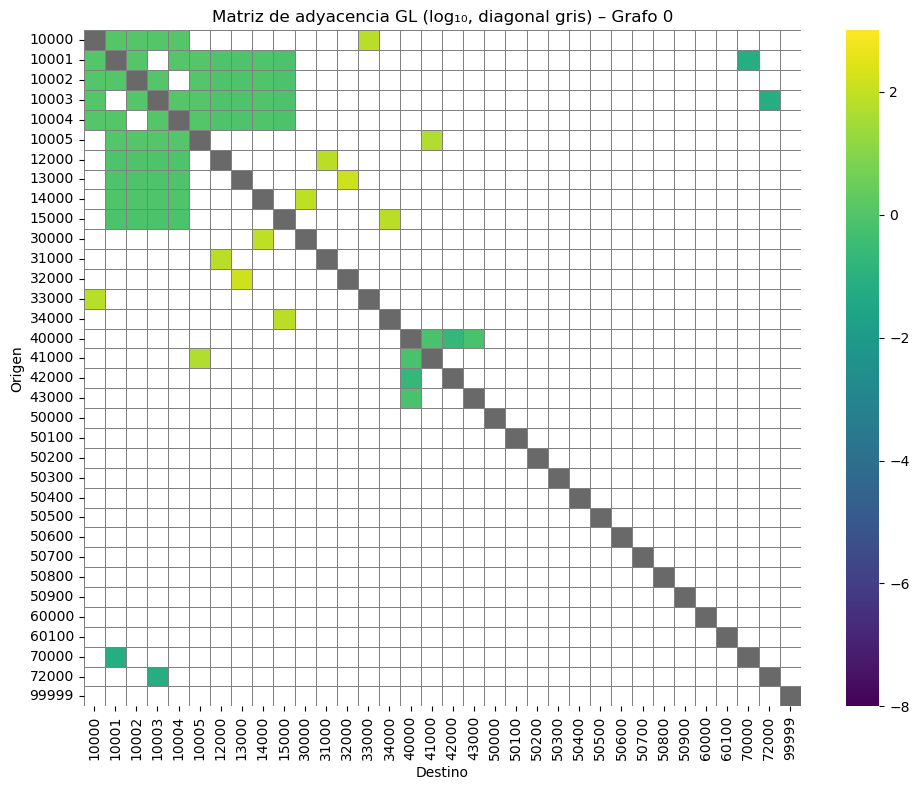

In [13]:
# Extraer datos del grafo
data = dataset[0]  # elige el grafo que quieras
edge_index = data.edge_index.numpy()
edge_attr = data.edge_attr.numpy()
external_ids = data.external_ids.tolist()

# === Crear matriz de adyacencia GL (reordenada y con diagonal en color especial) ===
n = len(external_ids)
adj_GL = np.zeros((n, n))

for idx, (u, v) in enumerate(edge_index.T):
    gl = edge_attr[idx, 0]
    if gl > 0:
        adj_GL[u, v] = gl

# Ordenar external_ids
external_ids_sorted = sorted(external_ids)
id_to_idx = {eid: i for i, eid in enumerate(external_ids)}
adj_GL_sorted = adj_GL[
    [id_to_idx[eid] for eid in external_ids_sorted],
    :][:, [id_to_idx[eid] for eid in external_ids_sorted]
]

# Aplicar log10 solo donde GL > 0
adj_GL_log = np.full_like(adj_GL_sorted, np.nan, dtype=float)
adj_GL_log[adj_GL_sorted > 0] = np.log10(adj_GL_sorted[adj_GL_sorted > 0])

# Marcar la diagonal como valor especial
for i in range(n):
    adj_GL_log[i, i] = -99  # valor fuera del rango normal (para color especial)

# Crear máscara para evitar que seaborn pinte etiquetas sobre la diagonal
mask = np.isnan(adj_GL_log)

# Dibujar heatmap
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap("viridis").copy()
cmap.set_under("dimgray")  # color especial para la diagonal

sns.heatmap(adj_GL_log, 
            cmap=cmap,
            linewidths=0.5, 
            linecolor='grey',
            vmin=-8, vmax=3,   # fija el rango de colores
            xticklabels=external_ids_sorted,
            yticklabels=external_ids_sorted,
            mask=mask)

plt.title(f"Matriz de adyacencia GL (log₁₀, diagonal gris) – Grafo {graph_idx}")
plt.xlabel("Destino")
plt.ylabel("Origen")
plt.tight_layout()
plt.show()


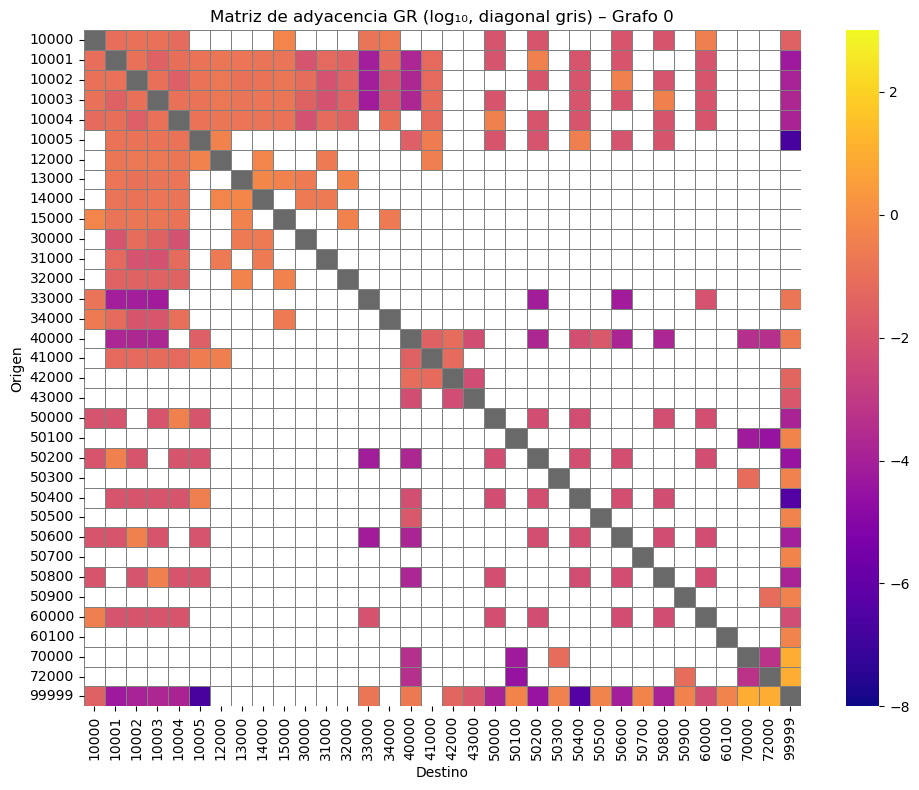

In [14]:
# Crear matriz de adyacencia GR
adj_GR = np.zeros((n, n))
for idx, (u, v) in enumerate(edge_index.T):
    gr = edge_attr[idx, 1]
    if gr > 0:
        adj_GR[u, v] = gr

# Reordenar matriz
adj_GR_sorted = adj_GR[
    [id_to_idx[eid] for eid in external_ids_sorted], 
    :][:, [id_to_idx[eid] for eid in external_ids_sorted]]

adj_GR_df = pd.DataFrame(
    np.log10(adj_GR_sorted, where=adj_GR_sorted > 0),
    index=external_ids_sorted,
    columns=external_ids_sorted
)

# Aplicar log10 solo donde GR > 0
adj_GR_log = np.full_like(adj_GR_sorted, np.nan, dtype=float)
adj_GR_log[adj_GR_sorted > 0] = np.log10(adj_GR_sorted[adj_GR_sorted > 0])

# Marcar la diagonal como valor especial
for i in range(n):
    adj_GR_log[i, i] = -99  # valor fuera del rango normal (para color especial)

# Crear máscara para evitar que seaborn pinte etiquetas sobre la diagonal
mask = np.isnan(adj_GR_log)

# Dibujar heatmap
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap("plasma").copy()
cmap.set_under("dimgray")  # color especial para la diagonal

sns.heatmap(adj_GR_log, 
            cmap=cmap,
            linewidths=0.5, 
            linecolor='grey',
            vmin=-8, vmax=3,   # fija el rango de colores
            xticklabels=external_ids_sorted,
            yticklabels=external_ids_sorted,
            mask=mask)

plt.title(f"Matriz de adyacencia GR (log₁₀, diagonal gris) – Grafo {graph_idx}")
plt.xlabel("Destino")
plt.ylabel("Origen")
plt.tight_layout()
plt.show()